# EnvBayes Notebook #1. Introduction to Bayesian Statistics for Environmental Science 

## Main Points
* Bayesian modeling can be thought of as a forward simulation Monte Carlo analysis that is fit to data. 
* Bayesian modeling a natural fit for environmental science. 

*Note: I have included all the code that generated this notebook, but have hidden all the code that slows down the presentation (e.g., plotting code).  My goal is that the reader does not need to click on any of the ">Click to Show" buttons.* 

## 1  Introduction

Most introductions to Bayesian statistics start with probability theory and simple toy examples such as a coin flip.  There are many examples out there, and [*Think Bayes*](https://greenteapress.com/wp/think-bayes/) by Allen Downey is a nice Python-flavored version.  

For environmental scientists, I like to introduce Bayesian statistics starting with a physical model.  Environmental science is rich in forward-simulation physical models, and, given the inherent uncertainty in environmental processes, model input parameters are frequently varied for an uncertainty or sensitivity analyses. This notebook shows how those forward simulations can then be fit to data using probability theory (i.e., Bayesian modeling).  I hope this alternative approach to introducing Bayesian statistics will resonate with some readers.

The rest of this notebook will step through a simple example by 1) presenting a model equation, 2) performing a forward simulation Monte Carlo analysis using the model, and 3) performing Bayesian inference on the model and data.    

## 2  Exponential Decay Model Equation

For this example, I will use a simple but real-life model from sediment remediation.  Suppose a bay that has been historically contaminated.  Some of that contamination gets bound up with particles and sinks to the sea floor.  We need to know: what will happen to that contamination over time?  

Let's consider only the most important processes in this system - the amount of fresh sediment that is coming in from rivers and runoff, contaminants that are bound up in that fresh sediment, and biological activity that mixes up that sediment.  The old but good SEDCAM model ([Jacobs et al. 1988](https://www.eopugetsound.org/sites/default/files/features/resources/PugetSoundResearch1988Vol2Optimized_0.pdf)) is an exponential decay model that incorporates just these processes, and can be written in the following form:  

$$
C_t = C_d(1-e^{-Rt/B}) + C_0e^{-Rt/B}
$$

Where:  
$C_t = $ the surface sediment contaminant concentration at time $t$   
$C_d = $ the contaminant concentration in depositing sediment  
$C_0 = $ the starting contaminant concentration  
$R = $ the sedimentation rate  
$t = $ time  
$B = $ depth of the biologically active zone  

The model is sufficient for our purpose, but highly simplified.  For example, the model ignores changes in sediment density within the sediment bed, degradation or dissolution of contaminants, and changes over time.  

### Python Implementation of the Model
Here is a Python implementation of the model.  

Imports

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

import pymc as pm
import arviz as az

Wrap the equation in a Python function.  

In [2]:
def sedcam(Cd, C0, R, t, B):
    return Cd * (1 - np.exp(-R*t/B)) + C0 * np.exp(-R*t/B)

Specify variable values for plotting. 

In [3]:
Cd = 10                     # ug/kg contaminant
C0 = 100                    # ug/kg contaminant
R = 1                       # cm/year
B = 10                      # cm
ts = np.linspace(0,30,100)  # years (0-30 in 100 increments)

Plot

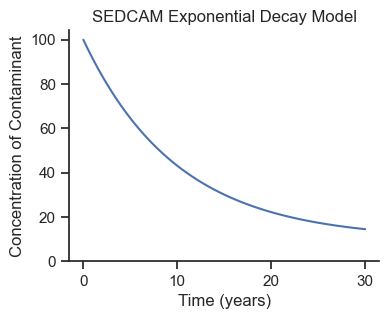

In [4]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(ts, sedcam(Cd, C0, R, ts, B))
ax.set_ylim(0)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Concentration of Contaminant')
ax.set_title('SEDCAM Exponential Decay Model');

Looks like an exponential decay model!  This is a good start, but we know our model is uncertain, so we will run a forward-simulation Monte Carlo analysis.  

## 3  Monte Carlo Simulation
Monte Carlo simulation is technique where uncertainty is explored by simulating random values from a probability distribution for each input parameter variable.  For each randomly selected combination of inputs, the output variable values are recorded to build up a distribution of potential output values.  The distribution of output values provide a range of potential outcomes, given the uncertainty in the input values.  The book [*EnvStats*](https://link.springer.com/book/10.1007/978-1-4614-8456-1) (Millard, 2013) explores Monte Carlo analysis for environmental risk estimation.  

Suppose that we generally know the deposition rate $R$ and the settling concentration $C_d$ to input into the model from literature and experience.  We think $R$ is about 1 cm/year with a standard deviation of 0.2, and $C_d$ is about 10 ug/kg with a standard deviation of 2.  We can specify these input variables as probability distributions in Pymc.

#### Pymc Simulation Model

In [5]:
# the distributions need to belong to the model
sedcam_monte = pm.Model()

# the with block tells the distributions who they belong to
with sedcam_monte:
    R = pm.Normal('R', mu=1, sigma=0.2)
    Cd = pm.Normal('Cd', mu=10, sigma=2)

#### Simulate
The forward simulation Monte Carlo analysis is run using the `pm.sample_prior_predictive` function.  We'll store the simulation in a variable `simulation.`  

In [6]:
monte_carlo_samples = 500  # number of iterations
# again, run the pymc functions in a with block
with sedcam_monte:
    simulation = pm.sample_prior_predictive(monte_carlo_samples)

#### Plot Random Draws

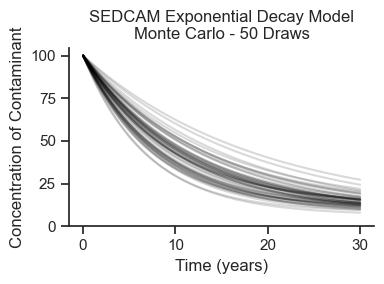

In [7]:
Cd0 = simulation.prior['Cd'].values.flatten()
R0 = simulation.prior['R'].values.flatten()
fig, ax = plt.subplots(figsize=(4,3))
draws = 50
for i in range(draws):
    ax.plot(ts, sedcam(Cd0[i], C0, R0[i], ts, B), color='black', alpha=.15)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Concentration of Contaminant')
ax.set_ylim(0)
ax.set_title(f'SEDCAM Exponential Decay Model\nMonte Carlo - {draws} Draws')
plt.tight_layout();

We see that the Monte Carlo simulation has generated a whole range of potential outcomes!  Let's look at the input distributions and the output distribution at year 10 to make sure that they are what we expect.  

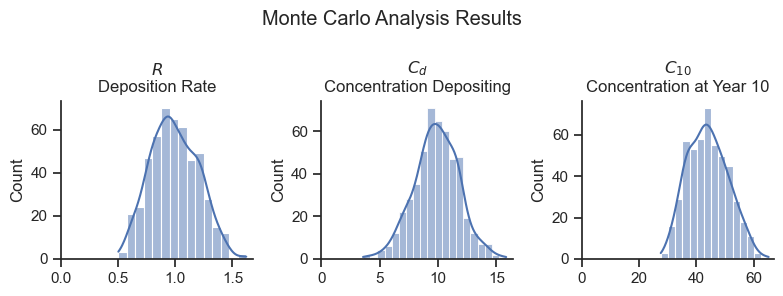

In [8]:
var_names=['R', 'Cd']
var_long_names = dict(zip(var_names, ['$R$\nDeposition Rate', '$C_d$\nConcentration Depositing']))
fig, axes = plt.subplots(1,3, figsize=(8,3))
for i, var_name in enumerate(var_names):
    ax = axes[i]
    sns.histplot(simulation.prior[var_name][0].values, ax=ax, kde=True)
    ax.set_xlim(0)
    ax.set_title(var_long_names[var_name])

ax = axes[2]
sns.histplot(sedcam(Cd0, C0, R0, 10, B), ax=ax, kde=True)
ax.set_xlim(0)
ax.set_title('$C_{10}$\nConcentration at Year 10')
plt.suptitle('Monte Carlo Analysis Results')
plt.tight_layout()


Looks about as expected!  The deposition rate and the depositing concentration are consistent with the input specification.  The resulting concentration at year 10 varies from about 30 to 65 ug/kg.  

This type of forward simulation is fairly common for environmental extrapolation problems.  For the next section, let's assume we have some data and turn this into a proper Bayesian model.

## 4  Bayesian Model

We used our experience and knowledge to extrapolate concentrations into the future and estimate uncertainty in those concentrations.  Now, let's assume we have data at year 10.  But, given the hard economic times, we only get one data point!  This happens to be at the low end of our range at 30 ug/kg.  Let's also assume that we know the measurement error in the value is 3 ug/kg (standard deviation) which we get from the laboratory report.  (Note this model does not include environmental  [i.e., sampling error] - another simplifying assumption for presentation purposes.)

In [9]:
# observed data
Ct_obs = 30      # ug/kg
sigma_Ct_obs = 3 # ug/kg
t_obs = 10       # years

### Pymc Model
We will rewrite the Pymc model to include the SEDCAM model equation and observed data.  

In [10]:
# make a pymc model called sedcam_bayes
sedcam_bayes = pm.Model()
with sedcam_bayes:
    # same as above - these are called priors
    R = pm.Normal('R', mu=1, sigma=0.2)
    Cd = pm.Normal('Cd', mu=10, sigma=2)
    
    # add the SEDCAM model equation - wrap it in a pm.Deterministic variable for tracking
    Ct = pm.Deterministic('Ct', 
        Cd * (1 - pm.math.exp(-R*t_obs/B)) + C0 * pm.math.exp(-R*t_obs/B))

    # add observed data - assume normal error (likelihood) around the predicted value Ct
    pm.Normal('Ct_modeled', mu=Ct, sigma=sigma_Ct_obs, observed=Ct_obs)

Above, we called `pm.sample_prior_predictive()`, which ignores any data in the model.  Now we call `pm.sample()`, which accounts the entire model.  In this step, probability theory (Bayes rule) is used to draw values from the posterior distribution, which considers both the prior probability distributions and the data.  The results are commonly called the "trace."  This is performed using sophisticated Markov Chain Monte Carlo (MCMC) methods under the hood in Pymc.

In [11]:
with sedcam_bayes:
    trace = pm.sample()
    post_pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [R, Cd]


Sampling 2 chains for 1_000 tune and 999 draw iterations (2_000 + 1_998 draws total) took 25 seconds.


#### Plot Results

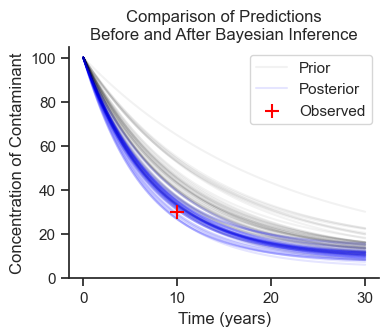

In [16]:
Cd0 = simulation.prior['Cd'].values.flatten()
R0 = simulation.prior['R'].values.flatten()
Cd = trace.posterior['Cd'].values.flatten()
R = trace.posterior['R'].values.flatten()
fig, ax = plt.subplots(figsize=(4,3))
for i in range(50):
    ax.plot(ts, sedcam(Cd0[i], C0, R0[i], ts, B), color='black', alpha=.05, label='Prior')
    ax.plot(ts, sedcam(Cd[i], C0, R[i], ts, B), color='blue', alpha=.1, label='Posterior')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Concentration of Contaminant')
ax.set_ylim(0)
ax.scatter(t_obs, Ct_obs, marker='+', s=100, label = 'Observed', 
         color='red', zorder=1000)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-3:], labels[-3:])
ax.set_title('Comparison of Predictions\nBefore and After Bayesian Inference');

Draws from the prior distribution (black) are wider and higher than the posterior distribution (blue).  The single observed data point tightened up our predictions!  But, importantly, uncertainty (i.e., probability distributions) are still part of the model.  

Let's plot the input parameters and the predicted concentration at year 10.  

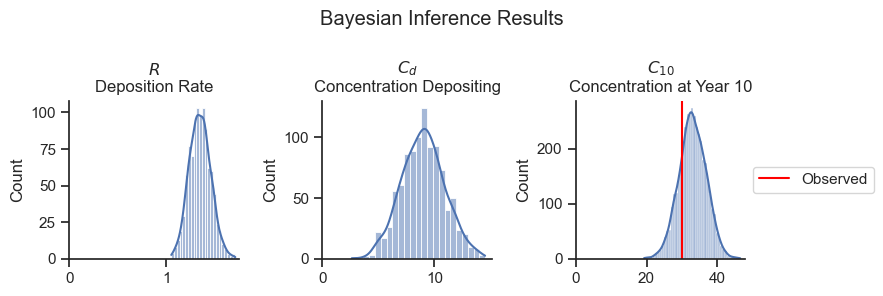

In [17]:
var_names=['R', 'Cd']
var_long_names = dict(zip(var_names, ['$R$\nDeposition Rate', '$C_d$\nConcentration Depositing']))
fig, axes = plt.subplots(1,3, figsize=(9,3))
for i, var_name in enumerate(var_names):
    ax = axes[i]
    sns.histplot(trace.posterior[var_name][0].values, ax=ax, kde=True)
    ax.set_xlim(0)
    ax.set_title(var_long_names[var_name])
ax = axes[2]
sns.histplot(post_pred.posterior_predictive['Ct_modeled'].values.flatten(), ax=ax, kde=True)
ax.set_xlim(0)
ax.set_title('$C_{10}$\nConcentration at Year 10')
ax.axvline(Ct_obs, color='red', label='Observed')
ax.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.suptitle('Bayesian Inference Results')
plt.tight_layout()

* As expected, the deposition rate $R$ has increased as a result of the data (compared to the prior), and the depositing concentration $C_d$ has decreased (slightly) compared to the prior. 
* The concentration at year 10 ($C_{10}$) has a tighter distribution after Bayesian inference.  The values center slightly above the observed data due to the combination of the observed data and the prior.  

The results of the Bayesian analysis can be summarized in a table using the Arviz package.  

#### Summary Table

In [18]:
az.summary(trace, hdi_prob=.90).iloc[:, :4].round(1)

,mean,sd,hdi_5%,hdi_95%
R,1.3,0.1,1.2,1.5
Cd,9.0,1.9,5.9,12.2
Ct,33.0,2.4,29.0,37.0


HDI (highest density interval) is similar to a confidence interval.  [Here](https://en.wikipedia.org/wiki/Credible_interval) is the Wikipedia article on the topic.   

## 5 Summary
My goal in writing this notebook was to show how a forward-simulation model can be turned into a Bayesian model.  Bayesian statistics and environmental data are a natural fit because of the plethora of forward simulation models, the small size of many data sets, and because uncertainty is important.

Here is how I depict the process of Bayesian inference:  

![BayesianInference](images/BayesianInference.png)

The Monte Carlo simulation is the first row of the diagram, where synthetic data can be generated using forward-simulation.  Bayesian inference then uses the forward simulation model and the observed data to recalculate model parameter distributions using inverse probability.  The posterior model parameter distributions will generally tighten up (become more certain) after "seeing" the data, as shown in the diagram.   

A couple of canonical examples opened my eyes to how Bayesian models can accommodate arbitrary data generating processes.  The [golf putting example](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/putting_workflow.html) models a dataset of golf putt successes (made/ not made) vs. distance from the hole.  The example compares a logistic regression model, which is the natural statistical model for modeling yes/ no results, to a basic physical model that incorporates the size of the golf ball, the size of the hole, and the angle of the putter head.  The physical model provides a much more realistic fit to the data. 

Another example is the [coal mine disaster analysis](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html#pymc-overview) which runs a switch-point regression on the classic coal miners dataset.  In this case, the model is simply two horizontal lines and a switch point.  Despite the simplicity of the model, it would be difficult to implement with coherent uncertainty estimates outside the Bayesian context.   

## 6 Next Steps
To reiterate, Bayesian statistics is just Monte Carlo simulation fit to data.  Once we know that, then we can apply statistics to all sorts of unique situations.  However, there are some components to the Bayesian workflow that are unique to this style of analysis.  The next notebook provides a template for reporting Bayesian analyses.  